In [2]:
import sys
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis\read")
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis")

import numpy as np
import matplotlib.pyplot as plt

from read_scope_data import read_trc_data
from data_analysis_utils import Photons, PhotonPulse


Reading data...
Done


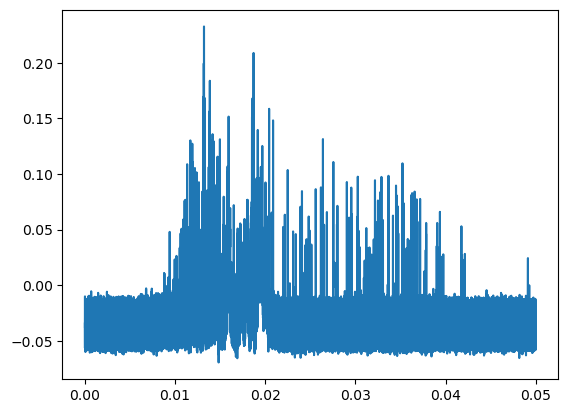

In [7]:
ifn = r"D:\x-ray\20241102\C3--E-ring-p24-z13-x40-xray--00045.trc"

data, tarr = read_trc_data(ifn)

plt.figure()
plt.plot(tarr, -data)
plt.show()

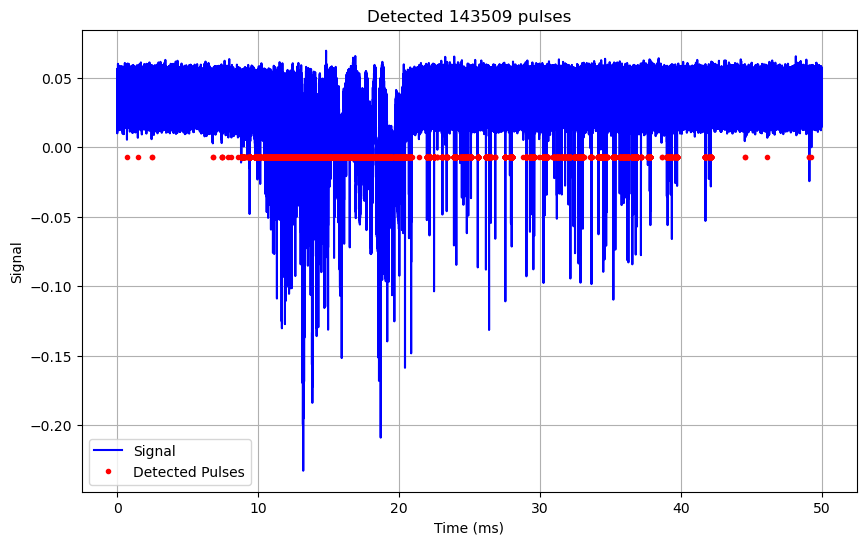


Detected 143509 pulses
Average pulse area: 0.69
Signal baseline: -0.04
Detection threshold: 0.03


In [20]:
# Convert time array from seconds to milliseconds
tarr_ms = tarr * 1000

# Create Photons detector object
detector = Photons(tarr_ms, -data, threshold_multiplier=5.0, negative_pulses=False)

# Reduce pulses to get pulse properties
detector.reduce_pulses()

# Get pulse arrays
pulse_times, pulse_areas = detector.get_pulse_arrays()

# Plot original signal with detected pulses
plt.figure(figsize=(10,6))
plt.plot(tarr_ms, data, 'b-', label='Signal')
plt.plot(pulse_times, [detector.threshold + detector.offset]*len(pulse_times), 
         'r.', label='Detected Pulses')
plt.xlabel('Time (ms)')
plt.ylabel('Signal')
plt.title(f'Detected {detector.pulse_count} pulses')
plt.legend()
plt.grid(True)
plt.show()

# Print some statistics
print(f"\nDetected {detector.pulse_count} pulses")
print(f"Average pulse area: {np.mean(pulse_areas):.2f}")
print(f"Signal baseline: {detector.offset:.2f}")
print(f"Detection threshold: {detector.threshold:.2f}")


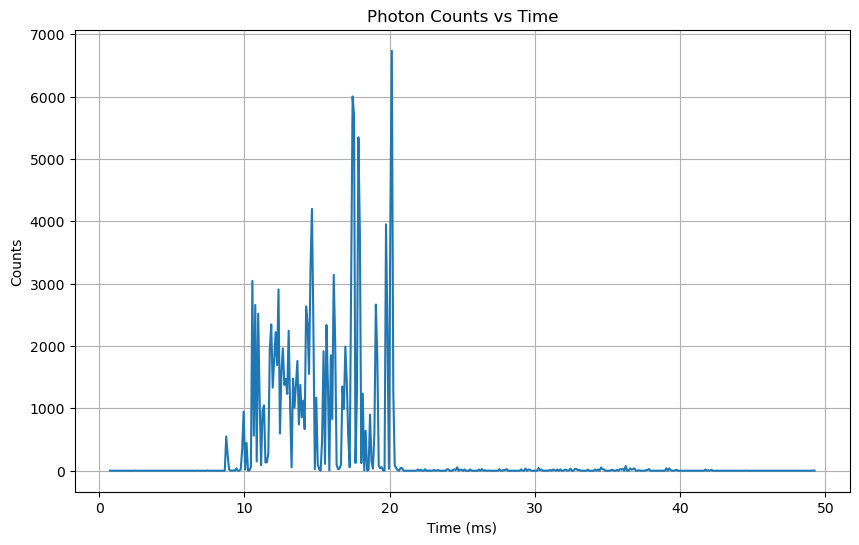

In [24]:
# Create histogram of pulses over time with adjustable bin width
bin_width = 0.1

plt.figure(figsize=(10,6))
bins = np.arange(min(pulse_times), max(pulse_times) + bin_width, bin_width)
hist, bins = np.histogram(pulse_times, bins=bins)
bin_centers = (bins[:-1] + bins[1:])/2

plt.plot(bin_centers, hist)
plt.xlabel('Time (ms)')
plt.ylabel('Counts') 
plt.title(f'Photon Counts vs Time')
plt.grid(True)
plt.show()


In [26]:
# Save histogram data, bin centers and time array to npz file
np.savez('photon_histogram.npz',
         counts=hist,
         bin_centers=bin_centers, 
         bin_width=bin_width,
         time_array=tarr_ms)
print("Saved histogram data to photon_histogram.npz")

Saved histogram data to photon_histogram.npz
